In [1]:
%load_ext watermark
%watermark

2018-11-05T13:07:29-08:00

CPython 3.6.6
IPython 7.0.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 18.0.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


In [2]:
# Import libraries
# ----------------

# Pandas
import pandas as pd

# numpy
import numpy as np

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# SciKit-Learn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import sklearn.metrics as metrics

from helpers import evaluate

In [3]:
raw_data_file = "../data/titanic.csv"
df = pd.read_csv(raw_data_file, usecols=['Name', 'Sex', 'Age', 'Survived'])
print('DataFrame shape: {}'.format(df.shape))
df.head()

DataFrame shape: (891, 4)


,Survived,Name,Sex,Age
0,0,"Braund, Mr. Owen Harris",male,22.0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0
2,1,"Heikkinen, Miss. Laina",female,26.0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0
4,0,"Allen, Mr. William Henry",male,35.0


## Data cleaning

In [4]:
# Percentage of missing values in each column
pd.DataFrame(
    df.isnull().sum() / len(df),
    columns=['% Missing Values']
).transpose()

,Survived,Name,Sex,Age
% Missing Values,0.0,0.0,0.0,0.198653


We're missing ~20% of the data for the Age variable.

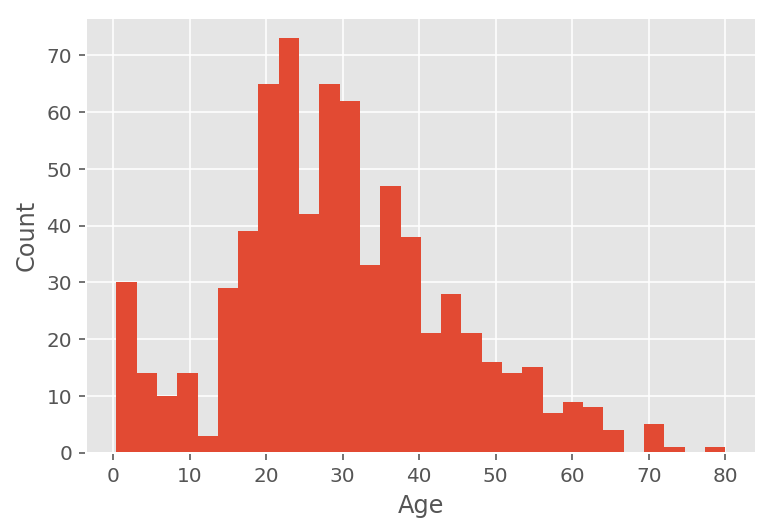

In [5]:
# Age histogram
df.Age.hist(bins=30)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

To impute data, we use the median as the distribution is skewed. The median is more robust against skewness like this than the mean.

In [6]:
df = df.fillna({'Age': df.Age.median(), })
df.head()

,Survived,Name,Sex,Age
0,0,"Braund, Mr. Owen Harris",male,22.0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0
2,1,"Heikkinen, Miss. Laina",female,26.0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0
4,0,"Allen, Mr. William Henry",male,35.0


In [7]:
df = df.astype({
    'Age': 'float64',
    'Name': 'object',
    'Sex': 'category',
    'Survived': 'int64',
})

Next, titles are created to capture the wealth of passangers. These are based on extracting portions of the name column and reducing them into 6 categories.

In [8]:
# Extract the Title from the name

simplify_title = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir": "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess": "Royalty",
    "Dona": "Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr": "Mr",
    "Mrs": "Mrs",
    "Miss": "Miss",
    "Master": "Master",
    "Lady": "Royalty"
}

df['Title'] = df['Name'].apply(
    lambda full_name: (
        simplify_title[
            # Example: Uruchurtu, Don. Manuel E --> Don
            full_name.split(',')[1].split('.')[0].strip()
        ]
    )
)

df['Title'] = df['Title'].astype('category')

df.head()

,Survived,Name,Sex,Age,Title
0,0,"Braund, Mr. Owen Harris",male,22.0,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,Mrs
2,1,"Heikkinen, Miss. Laina",female,26.0,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,Mrs
4,0,"Allen, Mr. William Henry",male,35.0,Mr


## Predictions 

In [9]:
# Select variables
df = df[['Age', 'Sex', 'Title', 'Survived']]

# One-hot encoding of categorical variables
df = pd.get_dummies(df, columns=['Sex', 'Title'])

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Survived', axis=1).values,
    df['Survived'].values,
    test_size=0.2,
    random_state=0
)

In [10]:
# parameters to optimize
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
parameters = { 'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

/Users/aidenarnold/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


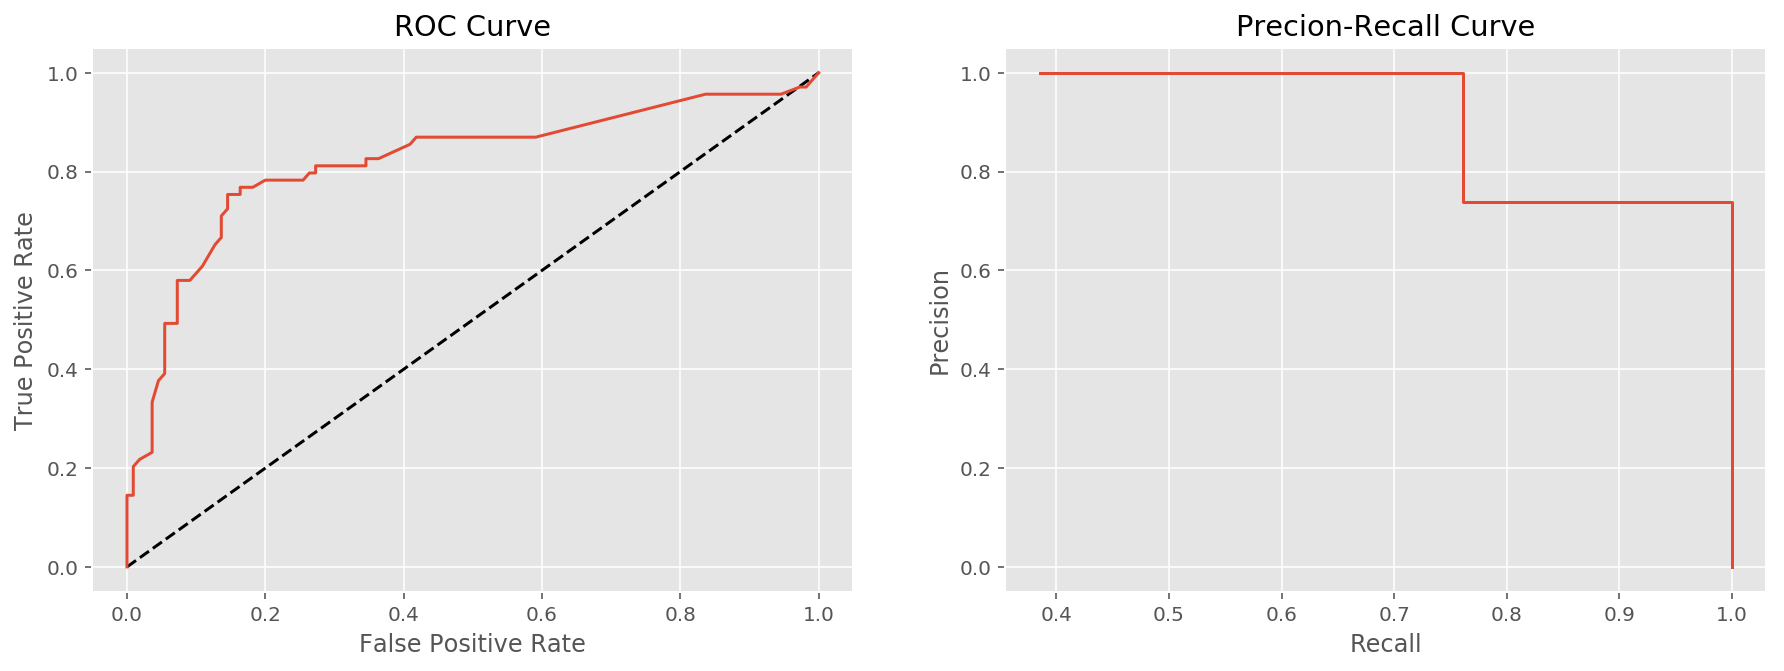

Accuracy on the training data is 0.802.
Accuracy on the test data is 0.81.
The model AUC for ROC curve of the test data is 0.819
Average precision is 0.663.
The best parameters are {'n_estimators': 944, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 100, 'bootstrap': True}.


In [11]:
# run grid search
rf_model = evaluate.model(RandomizedSearchCV(RandomForestClassifier(n_jobs=4), 
                                                param_distributions=parameters, n_iter=100, cv=5), 
                             data = (X_train, X_test, y_train, y_test), cv=True)